In [1]:
import logging 
from torch_geometric import seed_everything
import os
import configparser
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.INFO,
    filename='app.log',
    #filemode='w'
    filemode='a',
)
logging.info('This will get logged to a file')

In [2]:
%load_ext autoreload
%autoreload 1
from benchmark.preprocess import *
from benchmark.constants import *
from benchmark.db_import import *
from benchmark.ground_truth import *
from benchmark.construct_threatrace_graph import *
from benchmark.threatrace import *

2023-09-06 14:57:32


In [3]:
project_dir = os.getcwd()
print("Current project directory:", project_dir)

Current project directory: /Users/robinbuchta/Documents/GitHub/gnn_testenv/notebooks


In [4]:
# Read config file
config_dir = "../configs"
config_file_record_01 = config_dir + '/eng3/cadets/cadets_01_record.ini'
config_rec1= configparser.ConfigParser()
config_rec1.read(config_file_record_01)

['../configs/eng3/cadets/cadets_01_record.ini']

In [5]:
# # read tar file and extract to a folder + preprocess 
# process_darpa_data(config_rec1)
# #setup and import data to mariaDB 
# import_nodes_and_edges(config_rec1) 

In [6]:
#query = "SELECT * FROM cadets_edges_01_record LIMIT 10;"
query = "DESCRIBE cadets_edges_01_record;"
result = execute_query(config_rec1, query)
for i in result:
    print(i)

('id', 'int(11)', 'NO', 'PRI', None, 'auto_increment')
('event_parameters_array_size', 'text', 'YES', '', None, '')
('event_properties_map_arg_uid', 'int(11)', 'YES', '', None, '')
('event_location', 'text', 'YES', '', None, '')
('event_properties_map_arg_egid', 'varchar(255)', 'YES', '', None, '')
('event_parameters_array_tag', 'text', 'YES', '', None, '')
('event_properties_map_exec', 'varchar(255)', 'YES', '', None, '')
('event_parameters_array_type', 'text', 'YES', '', None, '')
('event_properties_map_cmdline', 'text', 'YES', '', None, '')
('event', 'text', 'YES', '', None, '')
('event_properties_map_login', 'varchar(255)', 'YES', '', None, '')
('event_parameters_array_name_string', 'text', 'YES', '', None, '')
('event_hostid', 'varchar(255)', 'YES', '', None, '')
('event_predicateobject2path', 'text', 'YES', '', None, '')
('event_predicateobjectpath_string', 'varchar(255)', 'YES', '', None, '')
('event_size_long', 'int(11)', 'YES', '', None, '')
('event_name', 'text', 'YES', '', N

In [7]:
connection = establish_connection(config_rec1)
cursor = connection.cursor()
# Get the list of table names in your database
cursor.execute("SHOW TABLES;")
tables = cursor.fetchall()
print(tables)

[('cadets_edges_01_record',), ('cadets_edges_03_record',), ('cadets_nodes_01_record',), ('cadets_nodes_03_record',), ('cadets_r03_tt_edges_test',), ('cadets_r03_tt_edges_train',), ('cadets_r03_tt_nodes_test',), ('cadets_r03_tt_nodes_train',), ('tmp1',)]


In [9]:
connection = establish_connection(config_rec1)
cursor = connection.cursor()
# Get the list of table names in your database
cursor.execute("SHOW TABLES;")
tables = cursor.fetchall()
print(tables)

def fetch_table_statistics(table_name):
    cursor.execute(f"SELECT * FROM {table_name} Limit 10;")
    column_names = [desc[0] for desc in cursor.description]
    print(column_names)
    cursor.fetchall()
    statistics = {}
    for column_name in column_names:
        query = f"SELECT {column_name}, COUNT(*) FROM {table_name} GROUP BY {column_name};"
        print(query)
        cursor.execute(query)

        result = cursor.fetchall()
        statistics[column_name] = result
    
    return statistics 
table_name = "cadets_nodes_01_record"
table_name = "cadets_edges_01_record"
print(f"Statistics for table: {table_name}")
statistics = fetch_table_statistics(table_name)

#runtime 43 min for table_name = "cadets_edges_01_record"


[('cadets_edges_01_record',), ('cadets_edges_03_record',), ('cadets_nodes_01_record',), ('cadets_nodes_03_record',), ('cadets_r03_tt_edges_test',), ('cadets_r03_tt_edges_train',), ('cadets_r03_tt_nodes_test',), ('cadets_r03_tt_nodes_train',), ('tmp1',)]
Statistics for table: cadets_edges_01_record
['id', 'event_parameters_array_size', 'event_properties_map_arg_uid', 'event_location', 'event_properties_map_arg_egid', 'event_parameters_array_tag', 'event_properties_map_exec', 'event_parameters_array_type', 'event_properties_map_cmdline', 'event', 'event_properties_map_login', 'event_parameters_array_name_string', 'event_hostid', 'event_predicateobject2path', 'event_predicateobjectpath_string', 'event_size_long', 'event_name', 'event_parameters_array_runtimedatatype', 'event_properties_map_ret_fd2', 'event_predicateobject', 'event_properties_map_arg_pid', 'event_properties_map_ppid', 'event_uuid', 'event_properties_map_fd', 'event_predicateobject_com_bbn_tc_schema_avro_cdm18_uuid', 'event

In [ ]:
# for column_name, values in statistics.items():
#     print(f"Column: {column_name}")
#     for value, count in values:
#         print(f"Value: {value}, Count: {count}")

# print("\n")


In [10]:
#save results to txt a folder and every column in a file
os.makedirs(f'{table_name}_table_statistics', exist_ok=True) 
for column_name, values in statistics.items(): 
    with open(f'{table_name}_table_statistics/{column_name}.txt', 'w') as f: 
        f.write(f"Column: {column_name}\n")  
        for value, count in values: 
            f.write(f"Value: {value}, Count: {count}\n") 
        






# with open(f'{table_name}_table_statistics.txt', 'w') as f:
#     for column_name, values in statistics.items():
#         f.write(f"Column: {column_name}\n")
#         for value, count in values:
#             f.write(f"Value: {value}, Count: {count}\n")
#         #f.write("\n")
#         f.write("-"*100)
#         f.write("-"*100)

In [ ]:
# Function to fetch unique value counts for a given table
def fetch_table_statistics(table_name):
    cursor.execute(f"SELECT * FROM {table_name};")
    column_names = [desc[0] for desc in cursor.description]
    
    statistics = {}
    for column_name in column_names:
        cursor.execute(f"SELECT {column_name}, COUNT(*) FROM {table_name} GROUP BY {column_name};")
        result = cursor.fetchall()
        statistics[column_name] = result
    
    return statistics

# Fetch statistics for each table in the database
for table in tables:
    table_name = table[0]
    print(f"Statistics for table: {table_name}")
    statistics = fetch_table_statistics(table_name)
    
    for column_name, values in statistics.items():
        print(f"Column: {column_name}")
        for value, count in values:
            print(f"Value: {value}, Count: {count}")
    
    print("\n")


In [4]:
# Read config file
config_dir = "../configs"
config_file_record_03 = config_dir + '/eng3/cadets/cadets_03_record.ini'
config_rec3 = configparser.ConfigParser()
config_rec3.read(config_file_record_03)


['../configs/eng3/cadets/cadets_03_record.ini']

In [5]:
# read tar file and extract to a folder + preprocess
process_darpa_data(config_rec3)


In [6]:
#setup and import data to mariaDB 
import_nodes_and_edges(config_rec3)

In [7]:
# create train and test data
mypygdata = MyPyGDataset(config_rec3, own_timestamp_percent=20, extension="20percentTrain") # 4min
data_train = mypygdata[0][0]
data_test = mypygdata[0][1]
print(data_train)
print(data_test)

Data(x=[154960, 56], edge_index=[2, 1738773], y=[154960], train_mask=[154960], test_mask=[154960])
Data(x=[574338, 56], edge_index=[2, 7375768], y=[574338], train_mask=[574338], test_mask=[574338])


In [8]:
# create ground truth 
gt_file1 = config_rec3['Files']['ground_truth'] # -> special case for record3, because here 2 attacks are given 
gt_file2 = config_rec3['Files']['ground_truth1'] # -> special case for record3, because here 2 attacks are given 
gts = [gt_file1, gt_file2]
gt = get_atk_nodes_for_evaluation(config_rec3, multi=True, gts=gts)

In [9]:
# create threatrace GNN anomaly detection Pipeline 
ttp = ThreaTracePipeline(data_train, data_test, config_rec3) 

In [10]:
#ttp.delete_old_models()
ttp.pretraining()
ttp.multi_model_training()

1 9.166815757751465 0.01567501290655653 2023-08-10 10:55:47
2 10.35104751586914 0.01610092927207021 2023-08-10 10:55:48
3 8.434337615966797 0.016894682498709346 2023-08-10 10:55:49
4 5.784651756286621 0.019869643779039752 2023-08-10 10:55:50
5 9.287395477294922 0.024193340216830148 2023-08-10 10:55:51
6 6.2006449699401855 0.03622870418172432 2023-08-10 10:55:52
7 9.684502601623535 0.0378291171915333 2023-08-10 10:55:53
8 7.72467565536499 0.043191791430046464 2023-08-10 10:55:54
9 6.591103553771973 0.4815952503871967 2023-08-10 10:55:55
10 7.101161479949951 0.4803755807950439 2023-08-10 10:55:56
11 5.838714599609375 0.4832537429013939 2023-08-10 10:55:56
12 7.653964042663574 0.48782266391326795 2023-08-10 10:55:57
13 9.503602981567383 0.4938887454827052 2023-08-10 10:55:58
14 7.744908332824707 0.5025619514713474 2023-08-10 10:55:59
15 5.208500862121582 0.5143069179143005 2023-08-10 10:55:59
16 4.623690128326416 0.5200761486835312 2023-08-10 10:56:00
17 2.7334868907928467 0.5416300980898

In [11]:
print("##############################################################################################################")
print("own evaluation")
print("##############################################################################################################")
ttp.reinit_test_data() 
ttp.test_model_performance() 


##############################################################################################################
own evaluation
##############################################################################################################
Loop_num: 0  Accuracy:0.7031  true_classified:403807  false_classified:170531
Loop_num: 1  Accuracy:0.1908  true_classified:109600  false_classified:464738
Loop_num: 2  Accuracy:0.0486  true_classified:27913  false_classified:546425
Loop_num: 3  Accuracy:0.1421  true_classified:81599  false_classified:492739
Loop_num: 4  Accuracy:0.0253  true_classified:14517  false_classified:559821
Loop_num: 5  Accuracy:0.0267  true_classified:15347  false_classified:558991
Loop_num: 6  Accuracy:0.0332  true_classified:19095  false_classified:555243
Loop_num: 7  Accuracy:0.6233  true_classified:357990  false_classified:216348
Loop_num: 8  Accuracy:0.0227  true_classified:13039  false_classified:561299
Loop_num: 9  Accuracy:0.0677  true_classified:38905  false_classifi

In [12]:
print("##############################################################################################################")
print("2 HOP")
hits = ttp.evaluation(gt)

# TP: 18234, FP: 0, TN: 549289, FN: 6815
# Precision:  0.9999999999999946
# Recall:  0.7279332508283736
# F-Score:  0.8425478824917251
# Accuracy:  0.9881341648994146

##############################################################################################################
2 HOP
{'tn': 574338}
start
{'tn': 574338}
set every node in gt to fn
{'fn': 25049, 'tn': 549289}
gt
{'fn': 25049, 'tn': 549289}


100%|██████████| 3325/3325 [06:01<00:00,  9.19it/s]


{'fn': 6673, 'tn': 549289, 'tp': 18376}
Intersection Counter: 3323
574338
18376 0 549289 6673
TP: 18376, FP: 0, TN: 549289, FN: 6673
Precision:  0.9999999999999947
Recall:  0.7336021398059774
F-Score:  0.8463327575792714
Accuracy:  0.9883814060709896


In [13]:
hits = ttp.evaluation_no_hop(gt)


start
{'tn': 574338}
set every node in gt to fn
{'fn': 25049, 'tn': 549289}


100%|██████████| 3325/3325 [00:00<00:00, 8313.06it/s]


{'fn': 24988, 'fp': 469, 'tn': 548820, 'tp': 61}
574338
61 469 548820 24988
TP: 61, FP: 469, TN: 548820, FN: 24988
Precision:  0.11509433962261978
Recall:  0.0024352269551678614
F-Score:  0.004769537507181492
Accuracy:  0.9556759260226556


In [14]:
ttp.get_detection_insights()

Get Detection Insights
Unique Count of data_flow.y:  (tensor([0, 1, 2, 3, 4, 5]), tensor([133448,  43080, 374521,  12657,  10510,    122]))
Unique Count of pred: (tensor([False,  True]), tensor([571013,   3325]))
Unique Count of filtered_tensor: (tensor([0, 1, 2, 3, 4, 5]), tensor([   6,    4,    8,   90, 3214,    3]))


tensor([4, 4, 4,  ..., 4, 4, 1])

In [15]:
hits = ttp.evaluation(gt, num_hops=1)

{'tn': 574338}
start
{'tn': 574338}
set every node in gt to fn
{'fn': 25049, 'tn': 549289}
gt
{'fn': 25049, 'tn': 549289}


100%|██████████| 3325/3325 [00:33<00:00, 98.92it/s] 


{'fn': 24959, 'tn': 549289, 'tp': 90}
Intersection Counter: 2879
574338
90 0 549289 24959
TP: 90, FP: 0, TN: 549289, FN: 24959
Precision:  0.9999999999988889
Recall:  0.003592957802706681
F-Score:  0.007160189346515892
Accuracy:  0.956543011258179


In [16]:
def create_boolean_tensor(length, true_positions):
    tensor = np.zeros(length, dtype=bool)
    tensor[true_positions] = True
    return torch.tensor(tensor)

In [17]:
x = len(ttp.test_data.test_mask)  # The length of the tensor
positions_list = np.random.choice(len(ttp.test_data.x), 3323).tolist()  # List of positions to set as True
print(positions_list)
boolean_tensor = create_boolean_tensor(x, positions_list)
print(boolean_tensor)
random_hits = ttp.evaluation_no_hop(gt, boolean_tensor) 

[486191, 451283, 165158, 220532, 514041, 318129, 565527, 9449, 416922, 139294, 491179, 564972, 532348, 79728, 73180, 486725, 238537, 573686, 461310, 366130, 153339, 414796, 522018, 312826, 242883, 23691, 283369, 338256, 50434, 148755, 47041, 399819, 265835, 406993, 68851, 126780, 88988, 123735, 102516, 31741, 180849, 134111, 270309, 224927, 8953, 291836, 271444, 363024, 114504, 440556, 327494, 459738, 125907, 477487, 337582, 543202, 159525, 521581, 334630, 68580, 114565, 527350, 43252, 108918, 58031, 264274, 379191, 406763, 285433, 509111, 158036, 175360, 305569, 290674, 131015, 145527, 390609, 371124, 43881, 269938, 324009, 23553, 443534, 321310, 450956, 413685, 449225, 449389, 539411, 537626, 379872, 253924, 18240, 499668, 12184, 465736, 332674, 349314, 215794, 184366, 54754, 361764, 507480, 55673, 473602, 286932, 285458, 115020, 461941, 507400, 69647, 100116, 455229, 223443, 542257, 102329, 65179, 438615, 206057, 13219, 358940, 562955, 465598, 71165, 466018, 320056, 412135, 10700, 4

100%|██████████| 3315/3315 [00:00<00:00, 8535.91it/s]


{'fn': 24894, 'fp': 14, 'tn': 549275, 'tp': 155}
574338
155 14 549275 24894
TP: 155, FP: 14, TN: 549275, FN: 24894
Precision:  0.9171597633130668
Recall:  0.0061878717713281725
F-Score:  0.012292806724023478
Accuracy:  0.9566318091437446


In [18]:
hits = ttp.evaluation(gt, hits=boolean_tensor,num_hops=1)

{'tn': 574338}
start
{'tn': 574338}
set every node in gt to fn
{'fn': 25049, 'tn': 549289}
gt
{'fn': 25049, 'tn': 549289}


100%|██████████| 3315/3315 [00:29<00:00, 110.67it/s]


{'fn': 24660, 'fp': 1, 'tn': 549288, 'tp': 389}
Intersection Counter: 438
574338
389 1 549288 24660
TP: 389, FP: 1, TN: 549288, FN: 24660
Precision:  0.9974358974356418
Recall:  0.015529562058365542
F-Score:  0.030582963163771754
Accuracy:  0.9570618694914841


In [19]:
x = len(ttp.test_data.test_mask)  # The length of the tensor
positions_list = np.random.choice(len(ttp.test_data.x), 113).tolist()  # List of positions to set as True
print(positions_list)
boolean_tensor = create_boolean_tensor(x, positions_list)
print(boolean_tensor)
random_hits = ttp.evaluation(gt, boolean_tensor) 

# Accuracy:  0.9999947765949667
# TP: 18437, FP: 0, TN: 549289, FN: 6612
# Precision:  0.9999999999999947
# Recall:  0.7360373667611453
# F-Score:  0.8479510646616337
# Accuracy:  0.9884876153066661

[427937, 570121, 235256, 283441, 10332, 562334, 64202, 492326, 446734, 324474, 2643, 251, 163644, 517507, 154408, 95202, 283650, 408183, 371060, 264026, 535832, 252774, 156132, 442543, 106587, 309072, 375952, 348862, 173437, 463760, 401068, 539150, 31071, 7974, 281487, 344305, 413700, 445257, 54866, 247387, 45095, 475077, 176423, 160079, 412285, 341114, 338313, 92474, 149909, 441730, 328777, 89212, 214344, 125902, 370228, 11409, 132833, 571800, 126530, 450785, 216233, 143596, 69853, 236230, 462588, 184122, 298683, 140257, 265911, 63892, 519718, 426382, 284158, 74534, 59466, 330920, 520517, 37367, 103834, 17754, 169435, 111874, 188533, 394674, 90801, 204318, 409705, 138205, 385053, 285558, 187045, 323130, 394166, 284504, 68943, 104335, 16168, 52200, 156113, 73997, 105373, 104372, 519108, 175204, 41920, 220334, 442744, 74338, 27238, 261409, 37130, 407747, 568987]
tensor([False, False, False,  ..., False, False, False])
{'tn': 574338}
start
{'tn': 574338}
set every node in gt to fn
{'fn':

100%|██████████| 113/113 [00:06<00:00, 16.80it/s]


{'fn': 6503, 'tn': 549289, 'tp': 18546}
Intersection Counter: 113
574338
18546 0 549289 6503
TP: 18546, FP: 0, TN: 549289, FN: 6503
Precision:  0.9999999999999947
Recall:  0.7403888378777567
F-Score:  0.8508315173269544
Accuracy:  0.988677399022875


In [20]:
# hit_neighbor_count_list = []
# for i in tqdm(range(ttp.test_data.num_nodes)):
#     i_as_list = [i]
#     hit_neighbors, edge_index, mapping, edge_mask = k_hop_subgraph(i_as_list, num_hops=2, edge_index=ttp.test_data_undirected_edge_index)
#     hit_neighbor_count_list.append(len(hit_neighbors))
# print('Average number of hit neighbors: ', np.mean(hit_neighbor_count_list))
# print('Max number of hit neighbors: ', np.max(hit_neighbor_count_list))
# print('Min number of hit neighbors: ', np.min(hit_neighbor_count_list))



# 100%|██████████| 574338/574338 [25:11:59<00:00,  6.33it/s]        
# Average number of hit neighbors:  225559.81589760733
# Max number of hit neighbors:  428045
# Min number of hit neighbors:  1

In [21]:
# # save list hit_neighbor_count_list to file 
# with open('hit_neighbor_count_list_sorted.txt', 'w') as filehandle:
#     for listitem in hit_neighbor_count_list:
#         filehandle.write('%s\n' % listitem)d

In [22]:
# #sort list hit_neighbor_count_list high to low
# hit_neighbor_count_list.sort(reverse=True)

In [23]:
len(ttp.test_data.x)

574338

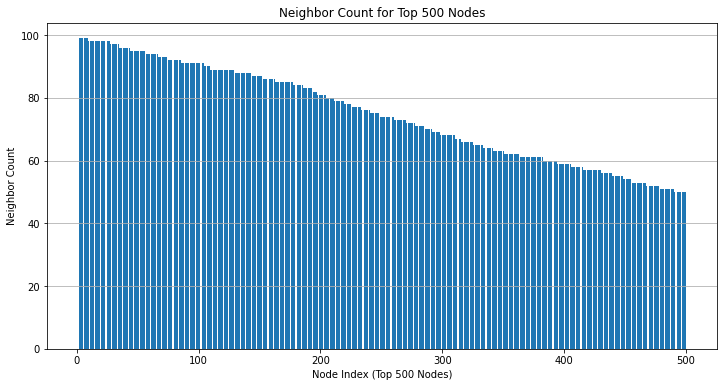

In [24]:
import matplotlib.pyplot as plt

# Assuming you have an array with neighbor count for each node
# Replace 'neighbor_count_array' with your actual data
# For demonstration, I'll create a random array of neighbor counts
np.random.seed(42)
neighbor_count_array = np.random.randint(0, 100, size=1000)

# Get the indices of the top 500 nodes based on neighbor count
top_500_nodes_indices = np.argsort(neighbor_count_array)[-500:][::-1]

# Get the neighbor count values for the top 500 nodes
top_500_neighbor_count = neighbor_count_array[top_500_nodes_indices]

# Plot the neighbor count for the top 500 nodes
plt.figure(figsize=(12, 6))
plt.bar(range(1, 501), top_500_neighbor_count)
plt.xlabel('Node Index (Top 500 Nodes)')
plt.ylabel('Neighbor Count')
plt.title('Neighbor Count for Top 500 Nodes')
plt.grid(axis='y')
plt.show()